# RNA-Seq Count Normalization

**Created**: 18 December 2021

## Environment

In [1]:
rm(list=ls())

if (!requireNamespace("BiocManager", quietly=TRUE)) {
    install.packages("BiocManager")
}

if (!require("limma", quietly=TRUE)) {
    BiocManager::install("limma")
}

if (!require("edgeR", quietly=TRUE)) {
    BiocManager::install("edgeR")
}

if (!require("Rtsne", quietly=TRUE)) {
    install.packages("Rtsne")
}

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘limma’”
'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.r-project.org


Bioconductor version 3.12 (BiocManager 1.30.16), R 4.0.5 (2021-03-31)

Installing package(s) 'limma'

Old packages: 'class', 'foreign', 'MASS', 'nlme', 'nnet', 'patchwork', 'WGCNA'

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘edgeR’”
'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.r-project.org


Bioconductor version 3.12 (BiocManager 1.30.16), R 4.0.5 (2021-03-31)

Installing package(s) 'edgeR'

also installing the dependency ‘locfit’


Old packages: 'class', 'foreign', 'MASS', 'nlme', 'nnet', 'patchwo

In [2]:
library(tidyverse)
library(data.table)
library(limma)
library(edgeR)
library(Rtsne)
library(parallel)

setwd("~/eQTL_pQTL_Characterization/")

source("03_Functional_Interpretation/scripts/utils/ggplot_theme.R")

── Attaching packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose




## Load Data

In [3]:
read.counts <- fread("~/gains_team282/epigenetics/calderon_et_al/analysis/rna_seq/gene_counts.tsv")

In [4]:
head(read.counts)

Gene,SRR11007061,SRR11007062,SRR11007063,SRR11007064,SRR11007065,SRR11007066,SRR11007067,SRR11007068,SRR11007069,⋯,SRR7647807,SRR7647808,SRR7647809,SRR7647810,SRR7647811,SRR7647812,SRR7647813,SRR7647817,SRR7647818,SRR7647819
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000223972,0,0,0,0,0,0,0,1,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000227232,6,11,4,0,3,2,1,1,0,⋯,0,2,1,1,2,0,0,3,3,1
ENSG00000278267,0,2,0,0,0,0,0,1,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000243485,0,0,0,0,0,0,1,0,0,⋯,0,0,0,0,0,0,0,1,0,0
ENSG00000284332,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000237613,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [5]:
sample.info <- read.csv("03_Functional_Interpretation/metadata/reads_calderon_et_al_rna_seq.txt")

In [6]:
head(sample.info)

,Run,Assay.Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,cell_type,Center.Name,Consent,⋯,LibrarySelection,LibrarySource,lineage,Organism,Platform,ReleaseDate,Sample.Name,source_name,SRA.Study,Treatment
,<chr>,<chr>,<int>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,SRR11007061,RNA-Seq,192,8160479782,PRJNA484735,SAMN09768434,2579781267,CD8pos_T,GEO,public,⋯,cDNA,TRANSCRIPTOMIC,CD8,Homo sapiens,ILLUMINA,2020-02-04T00:00:00Z,GSM3319750,primary blood,SRP156452,no_treament
2,SRR11007062,RNA-Seq,195,15315982752,PRJNA484735,SAMN09768433,4836924733,CD8pos_T,GEO,public,⋯,cDNA,TRANSCRIPTOMIC,CD8,Homo sapiens,ILLUMINA,2020-02-04T00:00:00Z,GSM3319751,primary blood,SRP156452,treatment1
3,SRR11007063,RNA-Seq,195,13128598440,PRJNA484735,SAMN09768432,4155236675,Central_memory_CD8pos_T,GEO,public,⋯,cDNA,TRANSCRIPTOMIC,CD8,Homo sapiens,ILLUMINA,2020-02-04T00:00:00Z,GSM3319752,primary blood,SRP156452,no_treament
4,SRR11007064,RNA-Seq,193,4866405615,PRJNA484735,SAMN09768431,1546902050,Central_memory_CD8pos_T,GEO,public,⋯,cDNA,TRANSCRIPTOMIC,CD8,Homo sapiens,ILLUMINA,2020-02-04T00:00:00Z,GSM3319753,primary blood,SRP156452,treatment1
5,SRR11007065,RNA-Seq,195,9601276948,PRJNA484735,SAMN09768430,3023735003,Effector_memory_CD8pos_T,GEO,public,⋯,cDNA,TRANSCRIPTOMIC,CD8,Homo sapiens,ILLUMINA,2020-02-04T00:00:00Z,GSM3319754,primary blood,SRP156452,no_treament
6,SRR11007066,RNA-Seq,196,9273440229,PRJNA484735,SAMN09768429,2953466798,Effector_memory_CD8pos_T,GEO,public,⋯,cDNA,TRANSCRIPTOMIC,CD8,Homo sapiens,ILLUMINA,2020-02-04T00:00:00Z,GSM3319755,primary blood,SRP156452,treatment1


In [7]:
bam.qc <- read.csv("~/gains_team282/epigenetics/calderon_et_al/analysis/rna_seq/bam_qc_cleaned.csv")

In [8]:
head(bam.qc)

,Sample,reads,mapped.bases,sequenced.bases,secondary.alignments,first.pair.mapped,second.pair.mapped,both.in.pair.mapped,singletons.in.pair.mapped,duplicated.reads,⋯,std.insert.size,median.insert.size,mean.mapping.quality,GC.percentage,general.error.rate,number.of.mismatches,number.of.insertions,number.of.deletions,mean.coverage,std.coverage
,<chr>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<dbl>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
1,SRR11007061,134057859,94311619044,12128980021,24872590,67032569,67025290,134048726,9133,55042927,⋯,12873.910,143,53.1013,0.4674,0,0,906859,743785,30.4255,409.6123
2,SRR11007062,135516914,73615514760,10075120373,29239074,67759487,67757427,135479910,37004,63405851,⋯,11690.415,173,45.8336,0.4689,0,0,511673,533947,23.7488,316.1158
3,SRR11007063,108652899,75114064752,9485700085,70072583,54340292,54312607,108615142,37757,51216442,⋯,9678.093,152,27.2386,0.4590,0,0,695514,652627,24.2323,422.6562
4,SRR11007064,155957496,72882304355,11645969829,15678514,77980567,77976929,155919424,38072,92682267,⋯,9661.230,195,37.6463,0.4525,0,0,586976,493624,23.5123,512.4495
5,SRR11007065,124164147,106956231482,11440849134,10244691,62089374,62074773,124147234,16913,68063211,⋯,8096.443,166,29.6919,0.4364,0,0,722068,583931,34.5048,605.8173
6,SRR11007066,17161201,18394955966,1630969574,5437987,8581394,8579807,17159548,1653,4887075,⋯,10464.190,167,23.7819,0.5357,0,0,52470,63078,5.9343,56.5615


In [9]:
rna.seq.qc <- read.csv("~/gains_team282/epigenetics/calderon_et_al/analysis/rna_seq/rna_seq_qc_cleaned.csv")

In [10]:
head(rna.seq.qc)

,Sample,Bias.3.Prime,Bias.5.Prime,Bias.5.3.Ratio,read.pairs.aligned,aligned.to.genes,ambiguous.alignments,no.feature.assigned,not.aligned,exonic,intronic,intergenic,overlapping.exon,reads.at.junctions
,<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,SRR11007061,0.73,0.85,1.19,67024363,12464246,706568,11831938,0,12464246,8001694,3830244,400001,2618002
2,SRR11007062,0.24,1.08,3.29,67739955,2347542,160483,2738381,0,2347542,2338684,399697,102308,593395
3,SRR11007063,0.79,0.93,1.24,54307571,14118694,702154,6376143,0,14118694,5899904,476239,382502,3426349
4,SRR11007064,0.26,0.88,2.80,77959712,2402342,197878,1785599,0,2402342,1526582,259017,105801,473488
5,SRR11007065,0.73,0.86,1.22,62073617,16478134,908017,3150904,0,16478134,2736862,414042,374243,3525812
6,SRR11007066,0.71,0.98,1.35,8579774,2040460,151296,887038,0,2040460,768717,118321,92895,709789


In [11]:
qc <- merge(sample.info, bam.qc, by.x="Run", by.y="Sample") %>%
    merge(., rna.seq.qc, by.x="Run", by.y="Sample")

## Limma-Voom Modeling

### Count Matrix

Set up the count matrix in the format required for Limma.

In [18]:
count.mtx <- as.matrix(read.counts[,-1])
rownames(count.mtx) <- read.counts$Gene

In [19]:
head(count.mtx)

,SRR11007061,SRR11007062,SRR11007063,SRR11007064,SRR11007065,SRR11007066,SRR11007067,SRR11007068,SRR11007069,SRR11007070,⋯,SRR7647807,SRR7647808,SRR7647809,SRR7647810,SRR7647811,SRR7647812,SRR7647813,SRR7647817,SRR7647818,SRR7647819
ENSG00000223972,0,0,0,0,0,0,0,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000227232,6,11,4,0,3,2,1,1,0,2,⋯,0,2,1,1,2,0,0,3,3,1
ENSG00000278267,0,2,0,0,0,0,0,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000243485,0,0,0,0,0,0,1,0,0,0,⋯,0,0,0,0,0,0,0,1,0,0
ENSG00000284332,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000237613,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [27]:
filtered.samples <- qc$Run[qc$mean.mapping.quality > 15 & qc$reads > 1e7]
count.mtx <- count.mtx[, filtered.samples]

### Create Sample Groups

The samples are grouped using cell type and treatment condition. The cell type and treatment group for each sample is stored in `groups`.

In [28]:
cell.type <- sample.info[match(colnames(count.mtx), sample.info$Run), "cell_type"]
stimulated <- ifelse(sample.info[match(colnames(count.mtx), sample.info$Run), "Treatment"] == "no_treament", "Baseline", "Stimulated")
groups <- interaction(cell.type, stimulated, sep="_")
groups <- droplevels(groups)

The design matrix indicates which samples belong to which groups.

In [29]:
design <- model.matrix(~0 + groups)

I will also be normalizing the data by removing batch effects. The donor is used as a categorical batch. The 3' bias, mean mapping quality, and GC percentage will be used as quantitative batch effects.

In [30]:
donors <- factor(sample.info[match(colnames(count.mtx), sample.info$Run), "donor"])

In [31]:
covariates <- cbind(
    rna.seq.qc[match(colnames(count.mtx), rna.seq.qc$Sample), "Bias.3.Prime"],
    bam.qc[match(colnames(count.mtx), bam.qc$Sample), c("mean.mapping.quality", "GC.percentage")]
)
colnames(covariates) <- c("Bias.3.Prime", "mean.mapping.quality", "GC.percentage")

### Create DGEList

`edgeR` can be used to handle count matrices. We will use `voom` in the next step to process this `edgeR` object.

In [119]:
dge <- DGEList(count.mtx)

In [128]:
unique.biological.groups <- unique(groups)
dge.cpm <- cpm(dge)
cutoff <- 1

In [129]:
samples.to.exclude <- do.call(
    cbind,
    mclapply(
        unique.biological.groups,
        function(group) {
            apply(dge.cpm[,groups == group,drop=FALSE], 1, min) <= cutoff 
        },
        mc.cores=7
    )
)
samples.to.exclude <- apply(samples.to.exclude, 1, all)

In [130]:
dge <- dge[!samples.to.exclude,] 
dim(dge)

[1] 21803   164

In [131]:
dge <- DGEList(count.mtx.filtered)

Calculate normalization factors for the trimmed mean of M-values method.

In [132]:
dge <- calcNormFactors(dge, method="TMM")

### Voom

`voom` models a count matrix by empirically identifying the mean-variance relationship within the data. The count matrix can then be normalized and batch effects can be removed. The normalized data can be used in downstream analysis with `limma`.

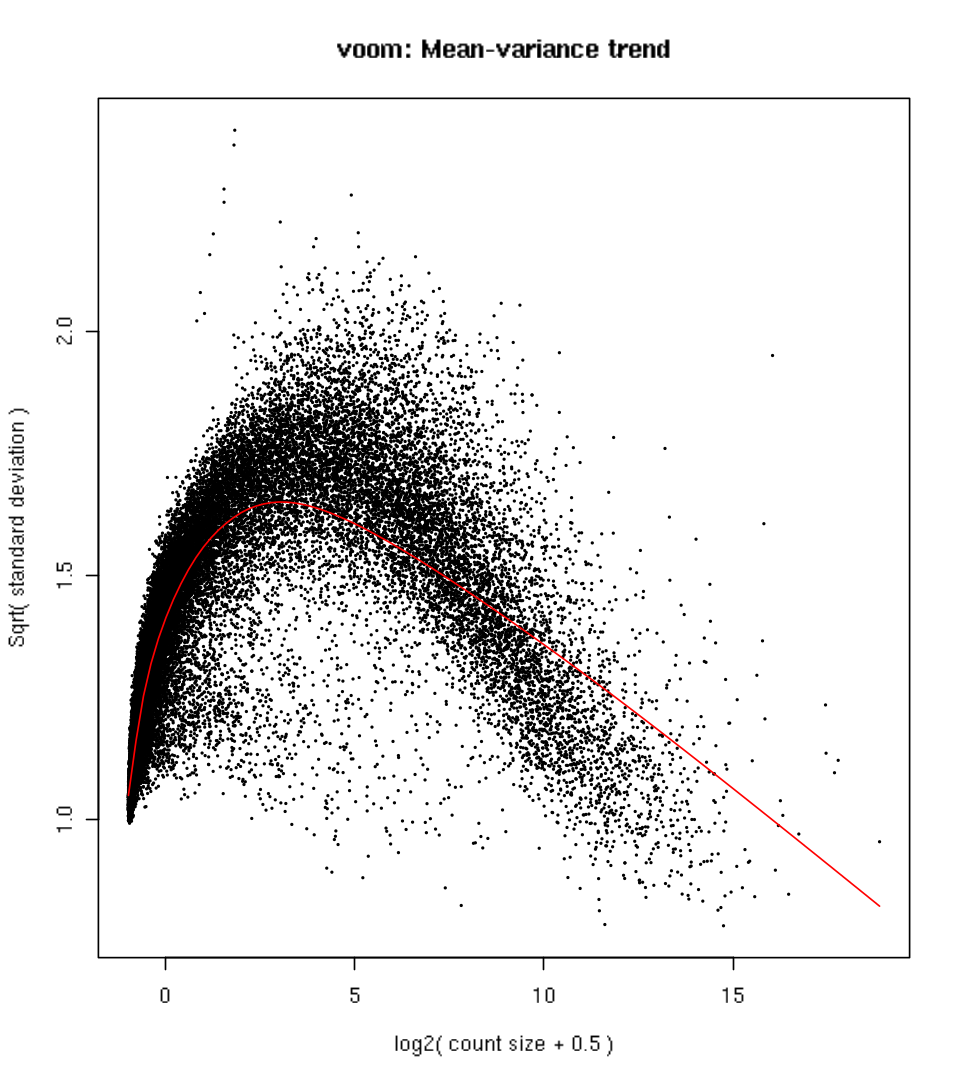

In [133]:
y <- voom(dge, design, plot=TRUE)

Correct batch effects by accounting for donors.

In [134]:
y.batch.corrected <- removeBatchEffect(y, batch=donors, covariates=covariates, design=design)

In [135]:
write.csv(y.batch.corrected, "~/gains_team282/epigenetics/calderon_et_al/analysis/rna_seq/counts_normalized.csv")

### Visualize Normalized Counts

In [136]:
pca <- prcomp(t(y.batch.corrected[,stimulated == "Baseline"]))

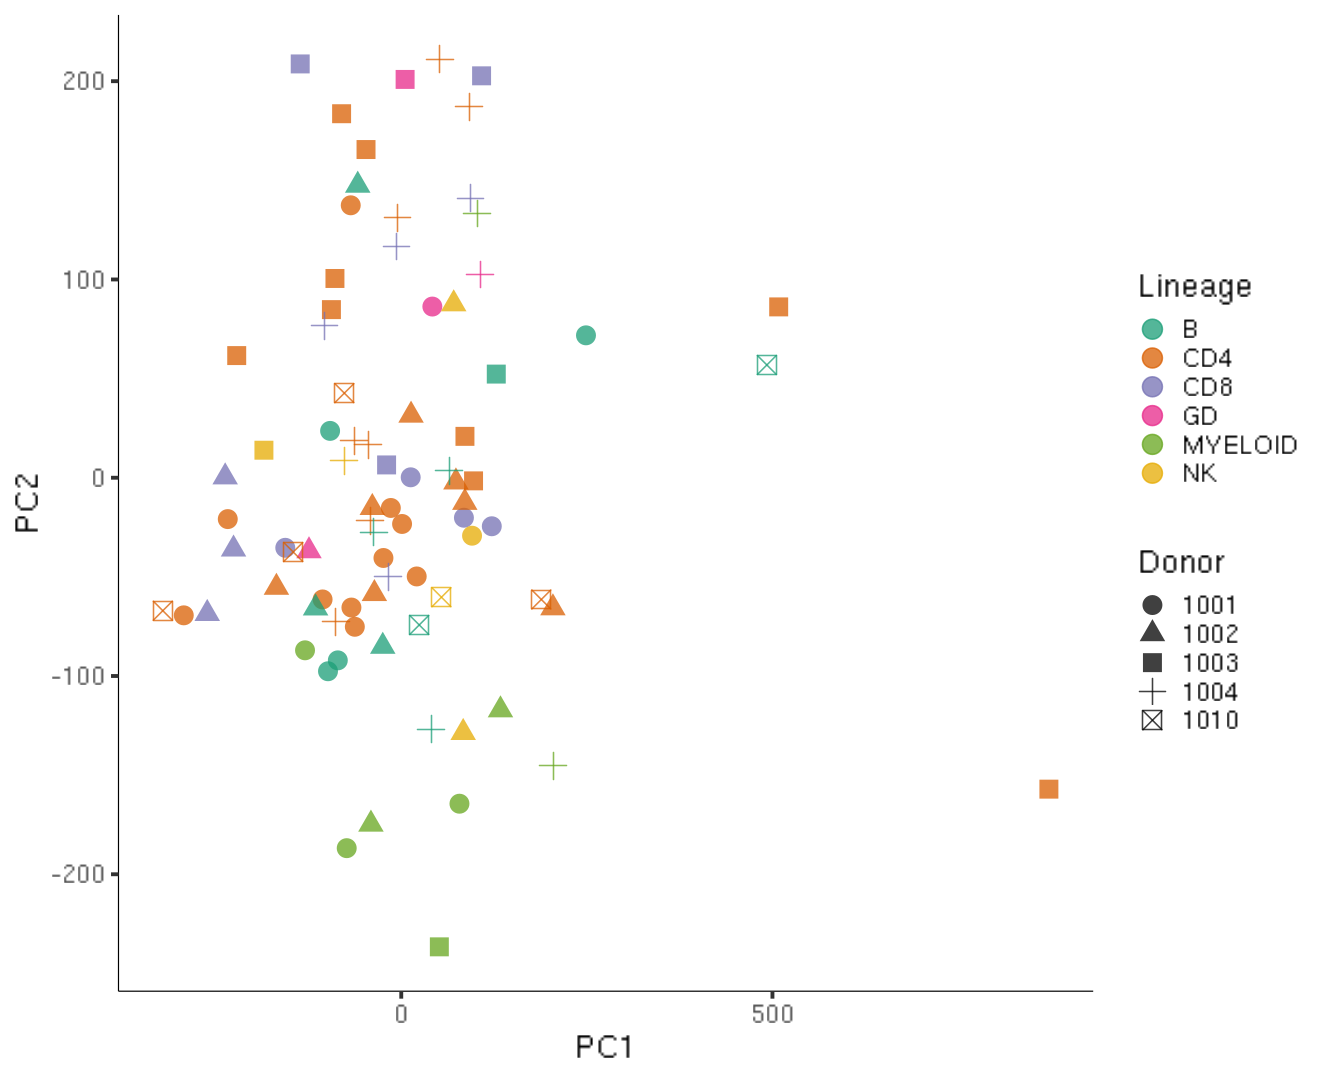

In [141]:
options(repr.plot.width=11, repr.plot.height=9)

merge(pca$x, sample.info, by.x=0, by.y="Run") %>%
    as.data.frame() %>%
    dplyr::mutate(Donor=as.factor(donor)) %>%
    ggplot() +
    geom_point(aes(x=PC1, y=PC2, color=lineage, shape=Donor), size=I(5), alpha=0.75) +
    scale_color_brewer(palette="Dark2") +
    labs(color="Lineage") +
    ggplot_theme +
    theme(legend.position="right")

ggsave("03_Functional_Interpretation/results/normalized_read_count_pca.svg", width=8, height=9)

In [150]:
set.seed(9873945)
tsne.res <- Rtsne(t(y.batch.corrected[,stimulated == "Baseline"]), num_threads=4, perplexity=10)

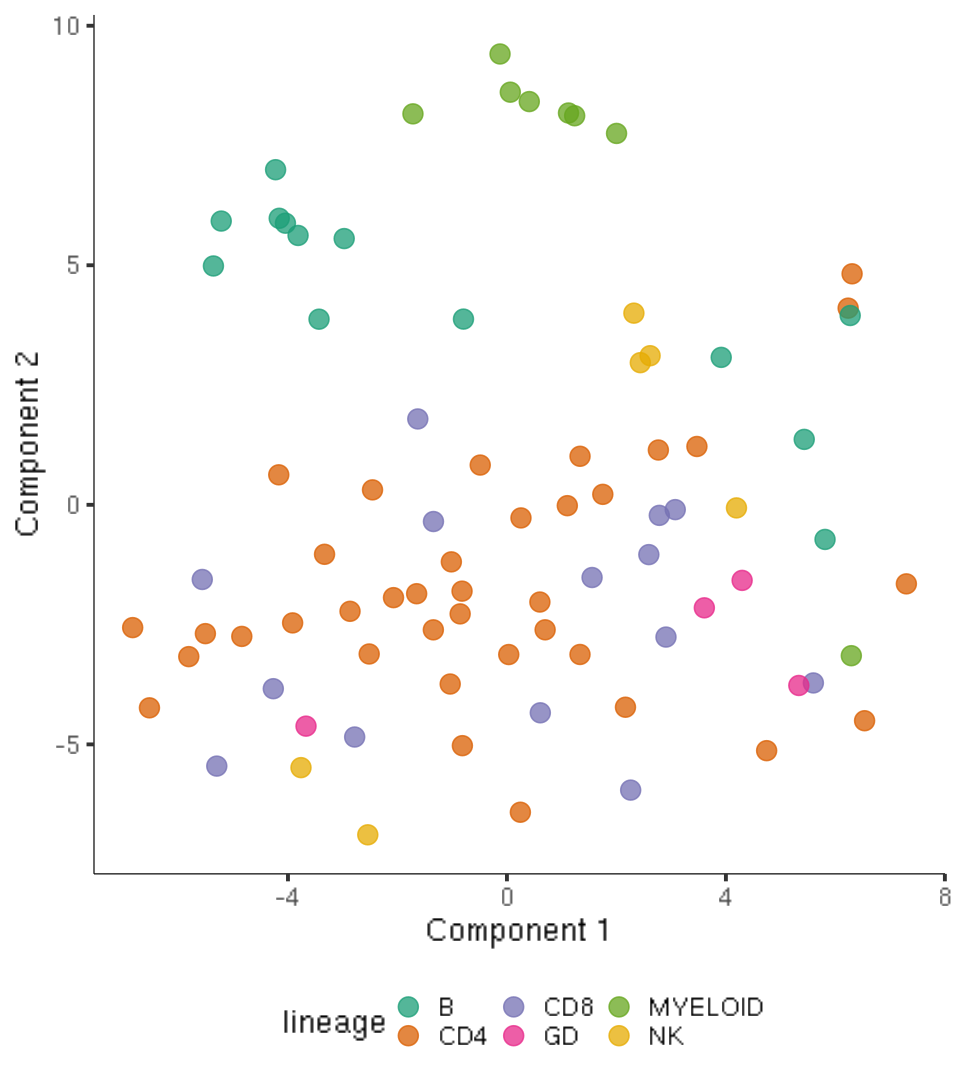

In [151]:
options(repr.plot.width=8, repr.plot.height=9)

tsne.res$Y %>%
    as.data.frame() %>%
    dplyr::select(Comp1=1, Comp2=2) %>%
    dplyr::mutate(Run=colnames(y.batch.corrected[,stimulated == "Baseline"])) %>%
    merge(., sample.info, by="Run") %>%
    ggplot() +
    geom_point(aes(x=Comp1, y=Comp2, color=lineage), size=I(5), alpha=0.75) +
    scale_color_brewer(palette="Dark2") +
    xlab("Component 1") + ylab("Component 2") +
    ggplot_theme

ggsave("03_Functional_Interpretation/results/normalized_read_count_tsne.svg", width=8, height=9)

### Limma

Use `limma` to fit a linear model consisting of the biological `groups`.

In [152]:
fit <- lmFit(y.batch.corrected, design)

#### DE Genes between Stimulated and Unstimulated Cells

Identify all cell types where both the baseline and stimulated conditions are present.

In [153]:
cell.type.conditions <- cbind(cell.type, stimulated) %>%
    as.data.frame() %>%
    dplyr::select(Cell.Type=1, Stimulated=2) %>%
    dplyr::group_by(Cell.Type, Stimulated) %>%
    dplyr::summarize(N=n(), .groups="drop") %>%
    tidyr::spread(Stimulated, N) %>%
    na.omit()

Create contrasts for each cell type that has both baseline and stimulated conditions.

In [154]:
contrast <- matrix(0, nrow=ncol(coef(fit)), ncol=nrow(cell.type.conditions))
rownames(contrast) <- colnames(coef(fit))
colnames(contrast) <- paste0(cell.type.conditions$Cell.Type, "_Stimulated-", cell.type.conditions$Cell.Type, "_Baseline")

for (i in 1:nrow(cell.type.conditions)) {
    cell.type.condition = cell.type.conditions$Cell.Type[i]
    contrast[paste0("groups", cell.type.condition, "_Stimulated"), i] = 1
    contrast[paste0("groups", cell.type.condition, "_Baseline"), i] = -1
}

In [155]:
de.genes <- rbindlist(lapply(1:ncol(contrast), function(i) {
    de.res = eBayes(contrasts.fit(fit, contrast[,i]))
    de.res.table = topTable(de.res, sort.by="p", n=Inf)
    
    contrast.cell.type = strsplit(colnames(contrast)[i], "-")[[1]][1]
    contrast.cell.type = substr(contrast.cell.type, start=1, stop=nchar(contrast.cell.type) - 11)

    de.res.table %>%
        dplyr::mutate(Contrast=colnames(contrast)[i]) %>%
        dplyr::mutate(Cell.Type=contrast.cell.type) %>%
        dplyr::mutate(Gene.ID=rownames(.)) %>%
        dplyr::select(Contrast, Cell.Type, Gene.ID, logFC, AveExpr, t, P.Value, adj.P.Val, B)
}))

## Differentially Expressed Genes

Calculate differentially expressed genes. For each contrast, a peak is considered differentially accessible if the adjusted P-value is < 0.01 and the absolute log fold change is greater than 1.

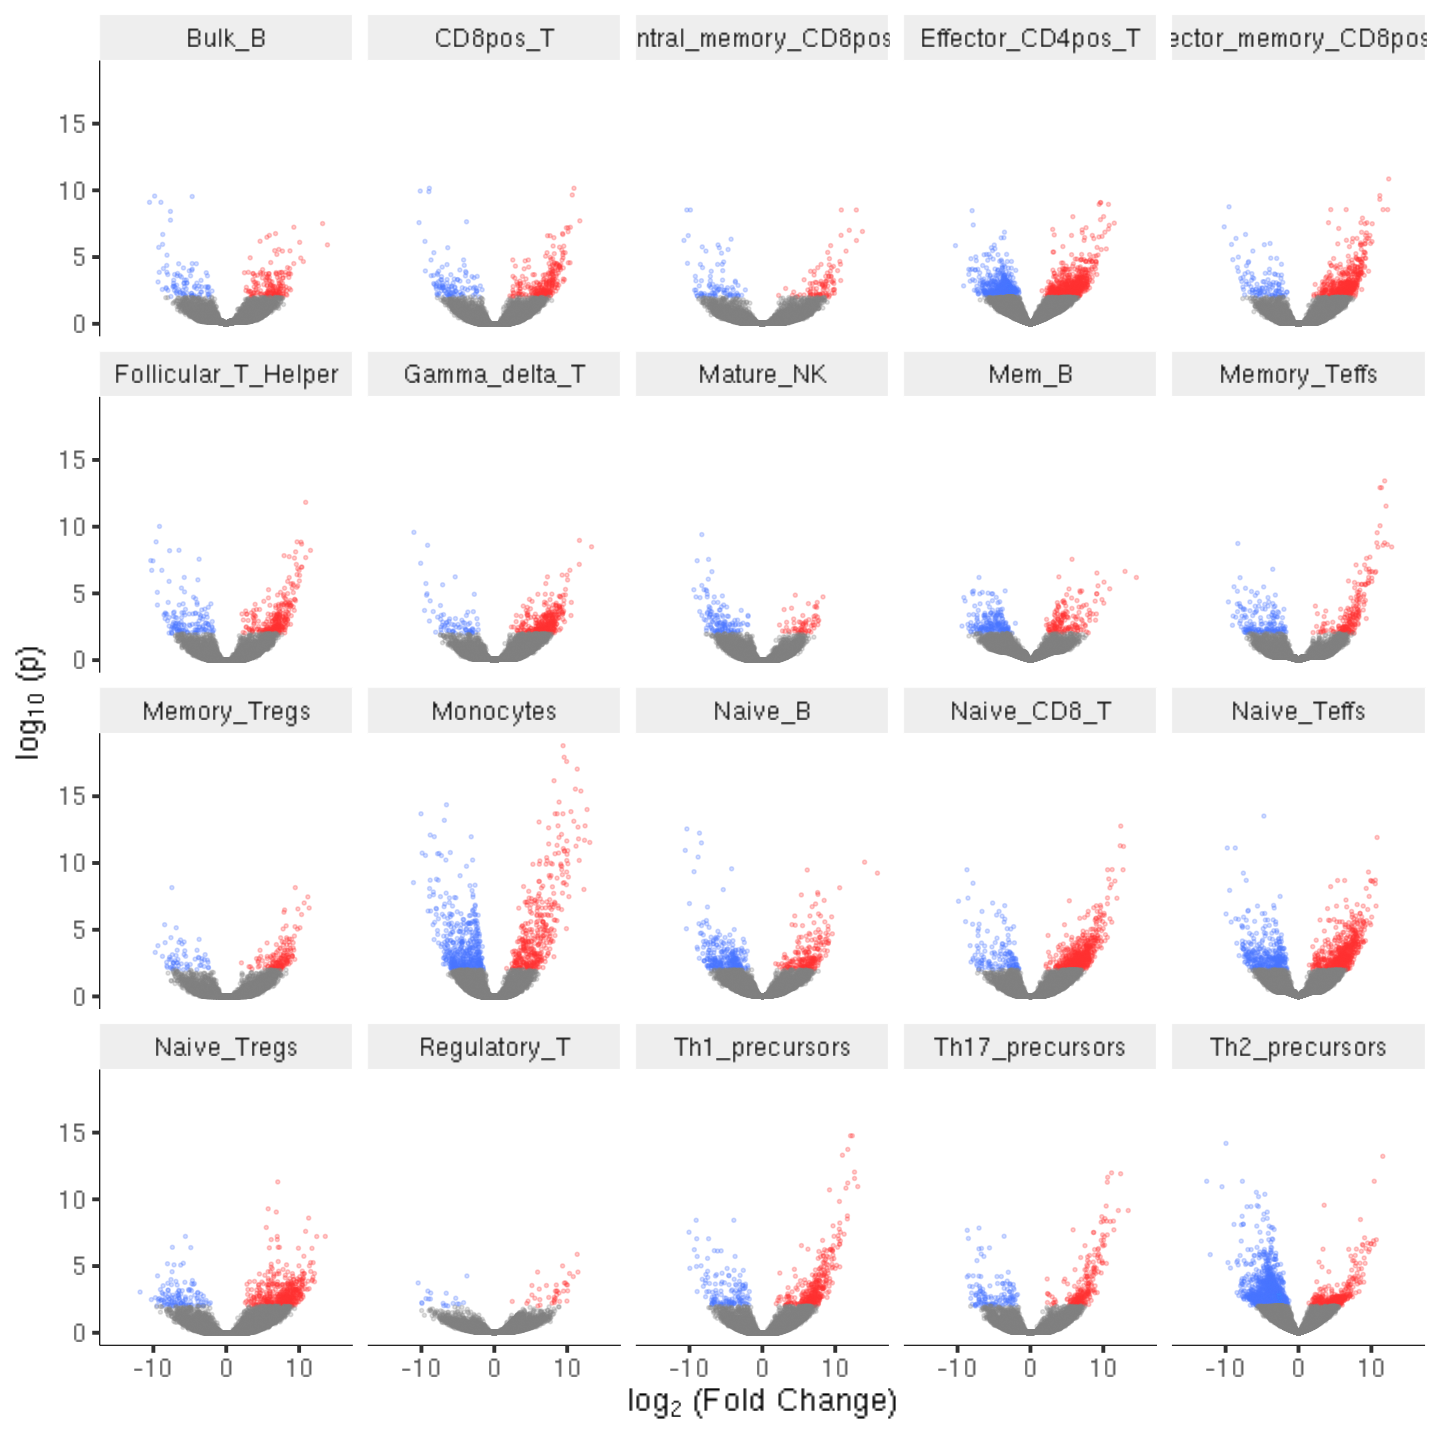

In [156]:
options(repr.plot.width=12, repr.plot.height=12)

abs.max.log.fc <- max(abs(de.genes$logFC))

de.genes %>%
    dplyr::mutate(log.adj.P.Val=-log10(adj.P.Val)) %>%
    dplyr::mutate(Accessible=ifelse(adj.P.Val < 0.01 & logFC > 1, "More", ifelse(adj.P.Val < 0.01 & logFC < -1, "Less", "Same"))) %>%
    ggplot() +
    geom_point(aes(x=logFC, y=log.adj.P.Val, color=Accessible), size=I(0.5), alpha=0.25) +
    scale_color_manual(values=c("More"="firebrick1", "Less"="royalblue1")) +
    guides(color="none") +
    facet_wrap(vars(Cell.Type)) +
    xlim(-abs.max.log.fc, abs.max.log.fc) +
    xlab(bquote("log"[2]~"(Fold Change)")) + ylab(bquote("log"[10]~"(p)")) +
    ggplot_theme

ggsave("03_Functional_Interpretation/results/de_genes_volcano_plots.png", width=12, height=12)

In [157]:
de.genes.set <- de.genes %>%
    dplyr::filter(abs(logFC) > 1) %>%
    dplyr::filter(adj.P.Val < 0.01)

write.csv(de.genes.set, "~/gains_team282/epigenetics/calderon_et_al/analysis/rna_seq/de_genes_set.csv")